In [1]:
engine ='duckdbparquet'

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 3, Finished, Available, Finished)

In [2]:
total_files  = 2300

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 4, Finished, Available, Finished)

In [3]:
Source       = "/lakehouse/default/Files/0_Source/ARCHIVE/Daily_Reports/"
Destination  = "/lakehouse/default/Files/1_Transform/0/ARCHIVE/Daily_Reports/"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 5, Finished, Available, Finished)

In [4]:
!pip install -q deltalake==0.17.4
!pip install -q duckdb

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 6, Finished, Available, Finished)

_**Import**_

In [5]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import time
from   datetime import datetime
from   deltalake.writer import write_deltalake
import glob
import os
from   psutil import *
import re 
import requests
from   shutil import unpack_archive
from   urllib.request import urlopen
import multiprocessing

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 7, Finished, Available, Finished)

In [6]:
## Max files to process in one loop
## (using Fabric medium single node 64 Gb RAM)
if   engine in  ["duckdb","daft","spark","duckdbparquet"] :
        max_chunk = total_files
elif engine in  ["polars"]  :
        max_chunk = 1500
elif engine in  ["pyarrow","chdb"] :
        max_chunk = 500
elif engine in  ["pandas"]  :
        max_chunk = 100

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 8, Finished, Available, Finished)

In [7]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 9, Finished, Available, Finished)

8 vCPU Memory:63.0


# Download Data

In [8]:
def download(url,Path,x):
    #run only once to create an empty log file
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True)
      os.makedirs(Path+"_log", exist_ok=True)
      log_tb = pa.Table.from_pylist( ['x'], schema=pa.schema({ "file" : pa.string()}))
      pq.write_table(log_tb,Path+"_log/log.parquet")
    # Regex don't ask I just copy it
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = dict.fromkeys(filelist1)
    filelist_sorted=sorted(filelist_unique, reverse=True)
    filelist = filelist_sorted[:x]
    ### Read from existing log
    try:
      df = ds.dataset(Path + "_log/log.parquet").to_table().to_pandas()
      file_loaded= df['file'].unique().tolist()
    except:
      os.makedirs(Path+"_log", exist_ok=True)
      file_loaded=[os.path.basename(x) for x in glob.glob(Path+'*.zip')]
    current = file_loaded
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload))
    print(str(len(files_to_upload)) + ' New File Loaded')
    if len(files_to_upload) != 0 :
      for x in files_to_upload:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}/{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)

    #print(log)
    L=[os.path.basename(x) for x in glob.glob(Path+'*.zip')]
    log = pd.DataFrame({'file':L})
    log_tb=pa.Table.from_pandas(log,preserve_index=False)
    #print(log_tb)
    log_schema = pa.schema([pa.field('file', pa.string())])
    log_tb=log_tb.cast(target_schema=log_schema)
    pq.write_table(log_tb,Path+"_log/log.parquet")
    return "done"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 10, Finished, Available, Finished)

In [9]:
def uncompress(x):
        unpack_archive(str(Source+x), str(Destination), 'zip')
def unzip(Source, Destination,Nbr_Files_to_Download):

    #run only once to create an empty log file
    if not os.path.exists(Destination):
      os.makedirs(Destination, exist_ok=True)
      os.makedirs(Destination+"_log", exist_ok=True)
      log_tb = pa.Table.from_pylist( ['x'], schema=pa.schema({ "file" : pa.string()}))
      pq.write_table(log_tb,Destination+"_log/log.parquet")
    # check zip files
    try:
     df = ds.dataset(Source + "_log/log.parquet").to_table().to_pandas()
     filelist_unique= df['file'].unique()
     filelist=filelist_unique.tolist()
    except:
     filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    filelist =sorted(filelist, reverse=True)
    ### checl the unzipped files already
    df = ds.dataset(Destination + "_log/log.parquet").to_table().to_pandas()
    file_loaded= df['file'].unique()
    current = file_loaded.tolist()
    files_to_upload = list(set(filelist) - set(current))
    files_to_upload = list(dict.fromkeys(files_to_upload))[:Nbr_Files_to_Download]
    #unzip only the delta
    print(str(len(files_to_upload)) + ' New File uncompressed')
    if len(files_to_upload) != 0 :
      with multiprocessing.Pool() as pool:
       for _ in pool.imap_unordered(uncompress, files_to_upload, chunksize=1):
         pass
      existing_file = pd.DataFrame( file_loaded)
      new_file = pd.DataFrame(  files_to_upload)
      log = pd.concat ([new_file,existing_file], ignore_index=True)
      #print(log)
      log.rename(columns={0: 'file'}, inplace=True)
      log_tb=pa.Table.from_pandas(log,preserve_index=False)
      #print(log_tb)
      log_schema = pa.schema([pa.field('file', pa.string())])
      log_tb=log_tb.cast(target_schema=log_schema)
      pq.write_table(log_tb,Destination+"_log/log.parquet")
      return "done"
    else:
     return "nothing to see here"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 11, Finished, Available, Finished)

<mark><u>_**For writing to Blobfuse, you need to pass those options**_</u></mark>

In [10]:
storage_options={"allow_unsafe_rename":"true"}
os.environ['MOUNT_ALLOW_UNSAFE_RENAME'] = "true"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 12, Finished, Available, Finished)

# 01 - Spark

In [11]:
# @title
def spark_clean_csv(files_to_upload_full_Path):
 from pyspark.sql import functions as f
 files_to_upload_full_Path_spark = ["file://" + w for w in files_to_upload_full_Path]
 user_schema="""
 I  STRING,UNIT  STRING,XX  STRING,VERSION  STRING,SETTLEMENTDATE  STRING,RUNNO  STRING,DUID  STRING,
 INTERVENTION  STRING,DISPATCHMODE  STRING,AGCSTATUS  STRING,INITIALMW  STRING,TOTALCLEARED  STRING,RAMPDOWNRATE  STRING,
 RAMPUPRATE  STRING,LOWER5MIN  STRING,LOWER60SEC  STRING,LOWER6SEC  STRING,RAISE5MIN  STRING,RAISE60SEC  STRING,RAISE6SEC  STRING,
 MARGINAL5MINVALUE  STRING,MARGINAL60SECVALUE  STRING,MARGINAL6SECVALUE  STRING,MARGINALVALUE  STRING,VIOLATION5MINDEGREE  STRING,
 VIOLATION60SECDEGREE  STRING,VIOLATION6SECDEGREE  STRING,VIOLATIONDEGREE  STRING,LOWERREG  STRING,RAISEREG  STRING,AVAILABILITY  STRING,
 RAISE6SECFLAGS  STRING,RAISE60SECFLAGS  STRING,RAISE5MINFLAGS  STRING,RAISEREGFLAGS  STRING,LOWER6SECFLAGS  STRING,LOWER60SECFLAGS STRING,
 LOWER5MINFLAGS  STRING,LOWERREGFLAGS  STRING,RAISEREGAVAILABILITY  STRING,RAISEREGENABLEMENTMAX  STRING,RAISEREGENABLEMENTMIN  STRING,
 LOWERREGAVAILABILITY  STRING,LOWERREGENABLEMENTMAX  STRING,LOWERREGENABLEMENTMIN  STRING,RAISE6SECACTUALAVAILABILITY  STRING,
 RAISE60SECACTUALAVAILABILITY  STRING,RAISE5MINACTUALAVAILABILITY  STRING,RAISEREGACTUALAVAILABILITY  STRING,
 LOWER6SECACTUALAVAILABILITY  STRING,LOWER60SECACTUALAVAILABILITY  STRING,LOWER5MINACTUALAVAILABILITY  STRING,
 LOWERREGACTUALAVAILABILITY  STRING
 """
 df = spark.read.format("csv")\
     .option("header","true") \
     .schema(user_schema)\
     .load(files_to_upload_full_Path_spark)\
     .filter("unit='DUNIT' and version =3 and I='D'")\
     .drop('xx','I')\
     .withColumn('SETTLEMENTDATE',f.to_timestamp('SETTLEMENTDATE','yyyy/MM/dd HH:mm:ss'))
 exclude_list = ['SETTLEMENTDATE','DUID','UNIT','PRIORITY']
 df = df.withColumns({i:f.col(i).cast("double") for i in df.columns if i not in exclude_list})
 df = df.withColumn('DATE', f.to_date(f.col('SETTLEMENTDATE')))\
      .withColumn('YEAR', f.year(f.col('SETTLEMENTDATE')))
 df.write.mode("overwrite").format("delta").partitionBy("YEAR").saveAsTable(f'T{total_files}.spark')
 return "done"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 13, Finished, Available, Finished)

# 02 - DuckDB

In [12]:
def duckdb_clean_csv(x):
	import duckdb
	raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)

	df=duckdb.sql(""" select UNIT, DUID,filename,cast(columns(*exclude(DUID,UNIT,SETTLEMENTDATE,I,XX,filename)) as double),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as year  from raw  """).record_batch()

	write_deltalake(f"/lakehouse/default/Tables/T{total_files}/duckdb",df, mode="append", partition_by=['year'], storage_options= storage_options)
	return "done"


StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 14, Finished, Available, Finished)

# 03 - Daft

In [13]:
def daft_clean_csv(files_to_upload_full_Path):
	!pip -q install  getdaft
	import daft
	from daft import DataType, col
	schema={
				'I': DataType.string(),'UNIT': DataType.string(),'XX': DataType.string(),'VERSION': DataType.string(),'SETTLEMENTDATE': DataType.string(),'RUNNO': DataType.string(),
				'DUID': DataType.string(),'INTERVENTION': DataType.string(),'DISPATCHMODE': DataType.string(),'AGCSTATUS': DataType.string(),'INITIALMW': DataType.string(),
				'TOTALCLEARED': DataType.string(),'RAMPDOWNRATE': DataType.string(),'RAMPUPRATE': DataType.string(),'LOWER5MIN': DataType.string(),
				'LOWER60SEC': DataType.string(),'LOWER6SEC': DataType.string(),'RAISE5MIN': DataType.string(),'RAISE60SEC': DataType.string(),
				'RAISE6SEC': DataType.string(),'MARGINAL5MINVALUE': DataType.string(),'MARGINAL60SECVALUE': DataType.string(),
				'MARGINAL6SECVALUE': DataType.string(),'MARGINALVALUE': DataType.string(),'VIOLATION5MINDEGREE': DataType.string(),
				'VIOLATION60SECDEGREE': DataType.string(),'VIOLATION6SECDEGREE': DataType.string(),'VIOLATIONDEGREE': DataType.string(),
				'LOWERREG': DataType.string(),'RAISEREG': DataType.string(),'AVAILABILITY': DataType.string(),'RAISE6SECFLAGS': DataType.string(),
				'RAISE60SECFLAGS': DataType.string(),'RAISE5MINFLAGS': DataType.string(),'RAISEREGFLAGS': DataType.string(),
				'LOWER6SECFLAGS': DataType.string(),'LOWER60SECFLAGS': DataType.string(),'LOWER5MINFLAGS': DataType.string(),
				'LOWERREGFLAGS': DataType.string(),'RAISEREGAVAILABILITY': DataType.string(),'RAISEREGENABLEMENTMAX': DataType.string(),
				'RAISEREGENABLEMENTMIN': DataType.string(),'LOWERREGAVAILABILITY': DataType.string(),'LOWERREGENABLEMENTMAX': DataType.string(),
				'LOWERREGENABLEMENTMIN': DataType.string(),'RAISE6SECACTUALAVAILABILITY': DataType.string(),
				'RAISE60SECACTUALAVAILABILITY': DataType.string(),'RAISE5MINACTUALAVAILABILITY': DataType.string(),
				'RAISEREGACTUALAVAILABILITY': DataType.string(),'LOWER6SECACTUALAVAILABILITY': DataType.string(),
				'LOWER60SECACTUALAVAILABILITY': DataType.string(),'LOWER5MINACTUALAVAILABILITY': DataType.string(),'LOWERREGACTUALAVAILABILITY': DataType.string()}
	df = daft.read_csv(files_to_upload_full_Path,schema=schema, infer_schema=False, has_headers=False, allow_variable_columns=True)
	df = df.where((df["UNIT"] == 'DUNIT' ) & (df["VERSION"] == '3') & (df["I"] == 'D'))
	df = df.exclude('I','XX')
	df_cols = list(set(df.column_names) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY'})
	for col_name in df_cols:
			df = df.with_column(col_name, col(col_name).cast(DataType.float64()))
	df = df.with_column("SETTLEMENTDATE", df["SETTLEMENTDATE"].str.to_datetime("%Y/%m/%d %H:%M:%S"))
	df = df.with_column('DATE', col('SETTLEMENTDATE').cast(DataType.date()))
	df = df.with_column('year', col('SETTLEMENTDATE').dt.year())
	df.write_deltalake(f"/lakehouse/default/Tables/T{total_files}/daft", mode="append" , partition_cols=["year"])
	return "done"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 15, Finished, Available, Finished)

# 04 - Polars

In [14]:
def polars_clean_csv(x):
  !pip -q install polars
  import polars as pl
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x, skip_rows=1, schema=schema, has_header=False,truncate_ragged_lines=True)
  transform =(
      raw
      .filter( (pl.col("I")=='D') &  (pl.col("UNIT")=='DUNIT') & (pl.col("VERSION")=='3') )
      .drop("XX","I")
  )
 
  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.collect_schema().names()) - {'SETTLEMENTDATE','DUID','UNIT','xxx'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),year=pl.col("SETTLEMENTDATE").dt.iso_year()).collect(streaming=True)
  final.write_delta(f"/lakehouse/default/Tables/T{total_files}/polars",mode="append",  storage_options= storage_options)
  return "done"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 16, Finished, Available, Finished)

# 05 - Pyarrow

In [15]:
def pyarrow_clean_csv(files_to_upload_full_Path):
  from pyarrow import csv
  import pyarrow.compute as pc
  import pyarrow as pa
  import pyarrow.dataset as ds
  new_schema = pa.schema([
  ('I', pa.string()),  ('UNIT', pa.string()),  ('XX', pa.string()),  ('VERSION', pa.float64()),  ('SETTLEMENTDATE', pa.string()),  ('RUNNO', pa.float64()),  ('DUID', pa.string()),  ('INTERVENTION', pa.float64()),
  ('DISPATCHMODE', pa.float64()),  ('AGCSTATUS', pa.float64()),  ('INITIALMW', pa.float64()),  ('TOTALCLEARED', pa.float64()),  ('RAMPDOWNRATE', pa.float64()),  ('RAMPUPRATE', pa.float64()),  ('LOWER5MIN', pa.float64()),
  ('LOWER60SEC', pa.float64()),  ('LOWER6SEC', pa.float64()),  ('RAISE5MIN', pa.float64()),  ('RAISE60SEC', pa.float64()),  ('RAISE6SEC', pa.float64()),  ('MARGINAL5MINVALUE', pa.float64()),  ('MARGINAL60SECVALUE', pa.float64()),
  ('MARGINAL6SECVALUE', pa.float64()),  ('MARGINALVALUE', pa.float64()),  ('VIOLATION5MINDEGREE', pa.float64()),  ('VIOLATION60SECDEGREE', pa.float64()),  ('VIOLATION6SECDEGREE', pa.float64()),  ('VIOLATIONDEGREE', pa.float64()),
  ('LOWERREG', pa.float64()),  ('RAISEREG', pa.float64()),  ('AVAILABILITY', pa.float64()),  ('RAISE6SECFLAGS', pa.float64()),  ('RAISE60SECFLAGS', pa.float64()),  ('RAISE5MINFLAGS', pa.float64()),
  ('RAISEREGFLAGS', pa.float64()),  ('LOWER6SECFLAGS', pa.float64()),  ('LOWER60SECFLAGS', pa.float64()),  ('LOWER5MINFLAGS', pa.float64()),  ('LOWERREGFLAGS', pa.float64()),  ('RAISEREGAVAILABILITY', pa.float64()),
  ('RAISEREGENABLEMENTMAX', pa.float64()),  ('RAISEREGENABLEMENTMIN', pa.float64()),  ('LOWERREGAVAILABILITY', pa.float64()),  ('LOWERREGENABLEMENTMAX', pa.float64()),  ('LOWERREGENABLEMENTMIN', pa.float64()),
  ('RAISE6SECACTUALAVAILABILITY', pa.float64()),  ('RAISE60SECACTUALAVAILABILITY', pa.float64()),  ('RAISE5MINACTUALAVAILABILITY', pa.float64()),  ('RAISEREGACTUALAVAILABILITY', pa.float64()),  ('LOWER6SECACTUALAVAILABILITY', pa.float64()),
  ('LOWER60SECACTUALAVAILABILITY', pa.float64()),  ('LOWER5MINACTUALAVAILABILITY', pa.float64()),  ('LOWERREGACTUALAVAILABILITY', pa.float64()),
    ])
  ReadOptions = csv.ReadOptions(column_names=new_schema.names,skip_rows=1)
  ParseOptions  = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions = csv.ConvertOptions(strings_can_be_null=True)
  format = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw = ds.dataset(files_to_upload_full_Path, format =format).filter((pc.field('I') == 'D') & (pc.field('UNIT') == 'DUNIT') & (pc.field('VERSION') == 3)).to_table().cast(new_schema)
  df= raw.drop_columns(['I','XX'])
  df = df.set_column(df.schema.get_field_index("SETTLEMENTDATE"), "SETTLEMENTDATE",pc.strptime(df['SETTLEMENTDATE'], format="%Y/%m/%d %H:%M:%S", unit='s').cast(pa.timestamp("s")))
  df = df.add_column(0,"year", pc.year(df['SETTLEMENTDATE']))
  write_deltalake(f"/lakehouse/default/Tables/T{total_files}/pyarrow",df, mode="append", partition_by=['year'], storage_options= storage_options)
  return "done"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 17, Finished, Available, Finished)

# 06 - Pandas

In [16]:
# @title
def pandas_clean_csv(chunk):
    import pyarrow as pa
    appended_data = []
    for filename in chunk:
        # Read only necessary columns
        df = pd.read_csv(filename, skiprows=1,dtype=str, names=range(131), keep_default_na=False,  index_col=False)
        df = df.iloc[:, :53]
        df = df.rename(columns={1: 'DISPATCH', 3: 'VERSION'}).query('DISPATCH=="DUNIT" and VERSION=="3"')
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'3': 'version', 'DUNIT': 'UNIT'})
        df = df.drop(columns=['I'])
        df.drop([""], axis=1, inplace=True)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        columns = list(set(df.columns) - {'SETTLEMENTDATE', 'DUID', 'UNIT'})
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce', dtype_backend='pyarrow')
        df['year'] = df['SETTLEMENTDATE'].dt.year
        appended_data.append(df)
    appended_data = pd.concat(appended_data, ignore_index=True)
    xx= pa.Table.from_pandas(appended_data,preserve_index=False)
    write_deltalake(f"/lakehouse/default/Tables/T{total_files}/pandas",xx, mode="append", partition_by=['year'],storage_options= storage_options)
    return "done"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 18, Finished, Available, Finished)

# 07 - Clickhouse

In [17]:
def chdb_clean_csv(files_to_upload_full_Path):
    !pip install   chdb
    L = tuple(files_to_upload_full_Path)
    sql =f"""
      with raw as ( SELECT   *, _file,_path  FROM file('/lakehouse/default/Files/1_Transform/0/ARCHIVE/Daily_Reports/*.CSV','CSV')
           WHERE c1 = 'D' AND c2 = 'DUNIT' AND c4 = '3' )
      select
      c2 as UNIT,
      toFloat64OrNull(c4) AS VERSION,
      parseDateTimeBestEffort( c5) AS SETTLEMENTDATE ,
      toFloat64OrNull(c6) AS RUNNO,
      c7  AS DUID,
      toFloat64OrNull(c8) AS INTERVENTION,
      toFloat64OrNull(c9) AS DISPATCHMODE,
      toFloat64OrNull(c10) AS AGCSTATUS,
      toFloat64OrNull(c11) AS INITIALMW,
      toFloat64OrNull(c12) AS TOTALCLEARED,
      toFloat64OrNull(c13) AS RAMPDOWNRATE,
      toFloat64OrNull(c14) AS RAMPUPRATE,
      toFloat64OrNull(c15) AS LOWER5MIN,
      toFloat64OrNull(c16) AS LOWER60SEC,
      toFloat64OrNull(c17) AS LOWER6SEC,
      toFloat64OrNull(c18) AS RAISE5MIN,
      toFloat64OrNull(c19) AS RAISE60SEC,
      toFloat64OrNull(c20) AS RAISE6SEC,
      toFloat64OrNull(c21) AS MARGINAL5MINVALUE,
      toFloat64OrNull(c22) AS MARGINAL60SECVALUE,
      toFloat64OrNull(c23) AS MARGINAL6SECVALUE,
      toFloat64OrNull(c24) AS MARGINALVALUE,
      toFloat64OrNull(c25) AS VIOLATION5MINDEGREE,
      toFloat64OrNull(c26) AS VIOLATION60SECDEGREE,
      toFloat64OrNull(c27) AS VIOLATION6SECDEGREE,
      toFloat64OrNull(c28) AS VIOLATIONDEGREE,
      toFloat64OrNull(c29) AS LOWERREG,
      toFloat64OrNull(c30) AS RAISEREG,
      toFloat64OrNull(c31) AS AVAILABILITY,
      toFloat64OrNull(c32) AS RAISE6SECFLAGS,
      toFloat64OrNull(c33) AS RAISE60SECFLAGS,
      toFloat64OrNull(c34) AS RAISE5MINFLAGS,
      toFloat64OrNull(c35) AS RAISEREGFLAGS,
      toFloat64OrNull(c36) AS LOWER6SECFLAGS,
      toFloat64OrNull(c37) AS LOWER60SECFLAGS,
      toFloat64OrNull(c38) AS LOWER5MINFLAGS,
      toFloat64OrNull(c39) AS LOWERREGFLAGS,
      toFloat64OrNull(c40) AS RAISEREGAVAILABILITY,
      toFloat64OrNull(c41) AS RAISEREGENABLEMENTMAX,
      toFloat64OrNull(c42) AS RAISEREGENABLEMENTMIN,
      toFloat64OrNull(c43) AS LOWERREGAVAILABILITY,
      toFloat64OrNull(c44) AS LOWERREGENABLEMENTMAX,
      toFloat64OrNull(c45) AS LOWERREGENABLEMENTMIN,
      toFloat64OrNull(c46) AS RAISE6SECACTUALAVAILABILITY,
      toFloat64OrNull(c47) AS RAISE60SECACTUALAVAILABILITY,
      toFloat64OrNull(c48) AS RAISE5MINACTUALAVAILABILITY,
      toFloat64OrNull(c49) AS RAISEREGACTUALAVAILABILITY,
      toFloat64OrNull(c50) AS LOWER6SECACTUALAVAILABILITY,
      toFloat64OrNull(c51) AS LOWER60SECACTUALAVAILABILITY,
      toFloat64OrNull(c52) AS LOWER5MINACTUALAVAILABILITY,
      toFloat64OrNull(c53) AS LOWERREGACTUALAVAILABILITY,
      _file as filename,
      toYear(CAST(SETTLEMENTDATE AS DateTime)) AS year
      from raw   where _path IN {L}
   """
    from chdb import session as chs
    sess = chs.Session()
    sess.query('''
    SET input_format_csv_use_best_effort_in_schema_inference = 0;
    SET input_format_csv_skip_first_lines = 1;
    SET input_format_csv_allow_variable_number_of_columns = 1 ;
               ''')
    df = sess.sql(sql,"ArrowTable")
    write_deltalake(f"/lakehouse/default/Tables/T{total_files}/chdb",df, mode="append", partition_by=['year'], storage_options= storage_options)
    del df
    return "done"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 19, Finished, Available, Finished)

# 08- Duckdb Parquet

In [18]:
def duckdbparquet_clean_csv(x):
    import duckdb
    from   deltalake import convert_to_deltalake
    raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)

    duckdb.sql(f"""
    copy( select UNIT, DUID,filename,cast(columns(*exclude(DUID,UNIT,SETTLEMENTDATE,I,XX,filename)) as double),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as year from raw )
    TO "/lakehouse/default/Tables/T{total_files}/duckdbparquet" (FORMAT PARQUET ,PARTITION_BY (year), OVERWRITE)
                     """)
					 
    destination = f"file:///lakehouse/default/Tables/T{total_files}/duckdbparquet/_delta_log"
    if notebookutils.fs.exists(destination): notebookutils.fs.rm(destination,recurse= True)
    convert_to_deltalake(f"/lakehouse/default/Tables/T{total_files}/duckdbparquet",
                         partition_by=pa.schema([('year', pa.int32())]),
                         partition_strategy='hive',
                         storage_options={"allow_unsafe_rename":"true"})
    return "done"

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 20, Finished, Available, Finished)

# ##########

# Run Test

In [19]:
def run_test(engine,chunk_len,files_to_upload_full_Path):
    results = pd.DataFrame(columns=['time','Engine','step','total_files','duration'])
    start_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    appended_data = []
    for i in range(0, len(files_to_upload_full_Path), chunk_len):
      chunk = files_to_upload_full_Path[i:i + chunk_len]
      start = time.time()
      eval(f"{engine}_clean_csv(chunk)")
      print(f'{engine} :' + str(time.time()-start))
      appended_data.append(pd.DataFrame([[start_time,engine,i,total_files,time.time()-start]], columns=results.columns))
    appended_data = pd.concat(appended_data, ignore_index=True)
    write_deltalake("/lakehouse/default/Tables/dbo/results",appended_data, mode="append",  storage_options= storage_options)

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 21, Finished, Available, Finished)

In [20]:
download("https://nemweb.com.au/Reports/Current/Daily_Reports/",Source,total_files)
unzip(Source,Destination,total_files)
list_files=[os.path.basename(x) for x in glob.glob(Destination+'*.CSV')]
files_to_upload_full_Path = [Destination + i for i in list_files][:total_files]
run_test(engine,max_chunk,files_to_upload_full_Path)

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 22, Submitted, Running, Running)

0 New File Loaded
0 New File uncompressed


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

rr /lakehouse/default/Tables/T2300/duckdbparquet/_delta_log/_commit_ab0f1d62-2309-4f05-996f-27ab336a215b.json.tmp -> /lakehouse/default/Tables/T2300/duckdbparquet/_delta_log/00000000000000000000.json
duckdbparquet :578.4302554130554
rr /lakehouse/default/Tables/dbo/results/_delta_log/_commit_3b2c44eb-61a8-4e54-8157-ff1029bace06.json.tmp -> /lakehouse/default/Tables/dbo/results/_delta_log/00000000000000000409.json


In [21]:
from deltalake import DeltaTable
dt = DeltaTable('/lakehouse/default/Tables/dbo/results',storage_options=  storage_options )
if len(dt.file_uris()) >= 50 :
            dt.optimize.compact()
            dt.vacuum(retention_hours=0,dry_run=False,  enforce_retention_duration=False)
            dt.cleanup_metadata()
            dt.create_checkpoint()

StatementMeta(, , , Waiting, , Waiting)

In [22]:
import duckdb
import time
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = vCPU+' '+str(mem)+'GB'+ ', Transform  CSV files and save as Delta Table,Run date: '+ str(time.strftime("%Y-%m-%d"))
result = duckdb.sql(""" 
                                   with raw as (
                                   select Engine, step,total_files, avg(duration) as duration
                                   from delta_scan('/lakehouse/default/Tables/dbo/results')
                                   where 1=1
                                   and total_files > 10
                                   and Engine in ('pyarrow','polars','daft','duckdb','spark','pandas','chdb','duckdbparquet')
                                   and time >'2024-09-29'
                                   group by all),
                                   result as (
                                   select Engine,total_files, round(sum(duration)/60,2) as duration from raw group by all order by duration)
                                   pivot result on Engine using avg(duration) order by total_files
                    """).df()


StatementMeta(, , , Waiting, , Waiting)

In [23]:
result

StatementMeta(, , , Waiting, , Waiting)

,total_files,chdb,daft,duckdb,duckdbparquet,pandas,polars,pyarrow,spark
0,60,1.04,1.01,1.03,0.34,5.54,1.07,1.33,1.58
1,2300,27.08,27.72,32.78,9.64,NaN,38.55,38.07,33.76


StatementMeta(, , , Waiting, , Waiting)

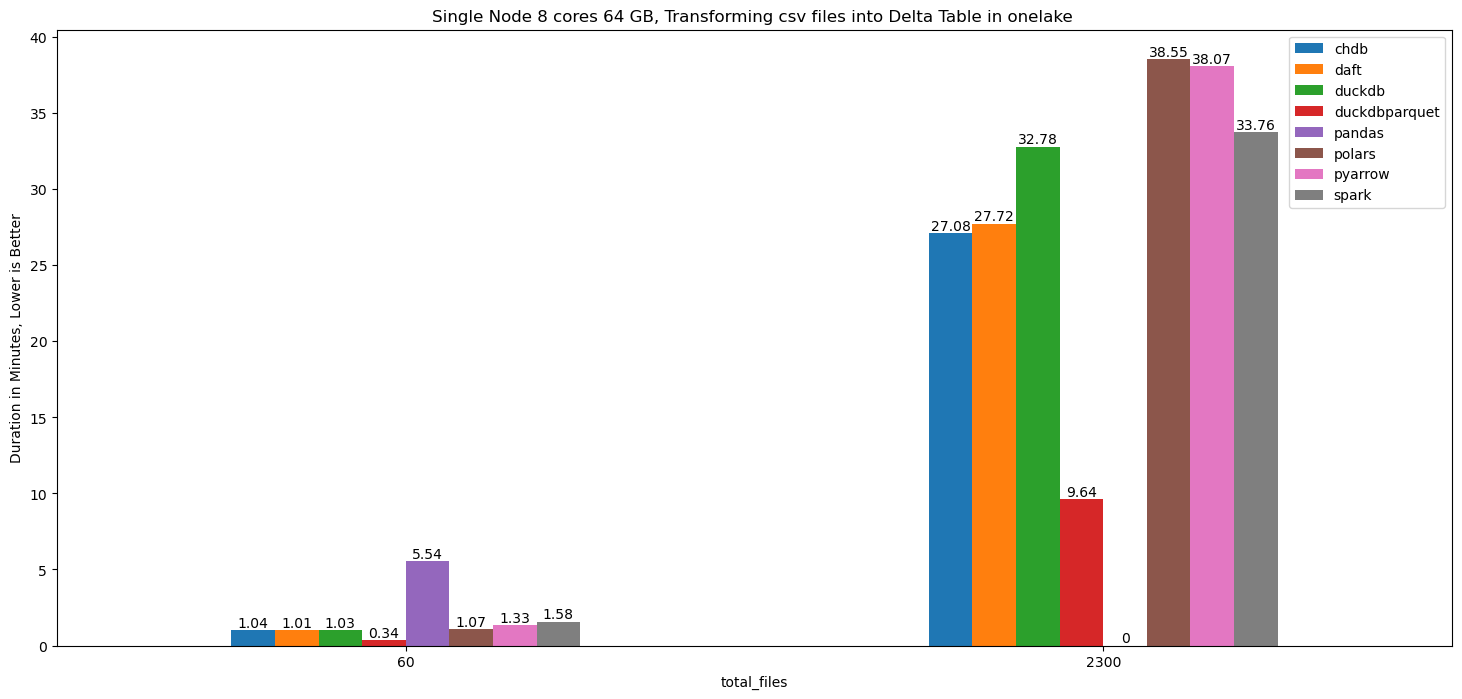

In [24]:
ax = result.plot.bar(rot=0,x='total_files',title="Single Node 8 cores 64 GB, Transforming csv files into Delta Table in onelake ",ylabel='Duration in Minutes, Lower is Better',figsize=(18,8))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

# Check File size output

In [25]:
# @title
#the function read all the tables in the default Lakehouse and save it in a Table Delta_stats, change the url to reflect your destination
import duckdb
import pandas as pd
from deltalake import DeltaTable
import os
from datetime import datetime
from deltalake.writer import write_deltalake
def get_stats(Source,Destination):
    appended_data = []
    List_tables = [ f.name for f in os.scandir(Source) if f.is_dir() ]
    stat_table = os.path.basename(os.path.normpath(Destination))
    if stat_table in List_tables: List_tables.remove(stat_table)
    for tbl in List_tables :
        dt = DeltaTable(Source+ tbl)
        xx= dt.get_add_actions(flatten=True).to_pandas()
        if 'tags.VORDER' in xx.columns:
             vorder =True
        else :
             vorder =False
        deltalog=pd.DataFrame([[tbl,xx['size_bytes'].sum(),vorder]],columns=['tbl','size_bytes','vorder'])
        delta = [Source+tbl + "/" + i for i in dt.files()]
        duckdb.sql(f'from parquet_scan({delta})').to_view(tbl)
        print(tbl)
        df= duckdb.sql(f'''
        with x as (
        select file_name,num_rows,num_row_groups, '{tbl}' as tbl from parquet_file_metadata({delta})
        )
        select x.tbl, file_name,num_rows,num_row_groups, ceil(size_bytes/(1024*1024)) as size,vorder from x
        left join deltalog as y
        on x.tbl=y.tbl
         ''').df()
        appended_data.append(df)
    appended_data = pd.concat(appended_data,ignore_index=True)
    appended_data['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    write_deltalake(Destination,appended_data,mode="overwrite",storage_options={"allow_unsafe_rename":"true"})

    dt = DeltaTable(Destination)
    delta = [Destination + "/" + i for i in dt.files()]
    duckdb.sql(f'from parquet_scan({delta})').to_view("xxx")

    duckdb.sql('''
    select tbl,
    sum(num_rows) as total_rows,
    count(*) as num_files,
    sum(num_row_groups) as num_row_group,
    cast(ceil(total_rows/num_row_group) as integer) as Average_row_group,
    min(size) as file_size_MB,
    vorder
    from xxx
    group by all
    order by file_size_MB ASC
    ''').show()


StatementMeta(, , , Waiting, , Waiting)

In [26]:
get_stats("/lakehouse/default/Tables/T2300/","/lakehouse/default/Tables/dbo/xx_deltastats")

StatementMeta(, , , Waiting, , Waiting)

duckdbparquet
chdb


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

daft


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

duckdb


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

polars


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

pyarrow


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

spark


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

rr /lakehouse/default/Tables/dbo/xx_deltastats/_delta_log/_commit_eb72be38-72f4-44c7-93cd-5053251d4e47.json.tmp -> /lakehouse/default/Tables/dbo/xx_deltastats/_delta_log/00000000000000000022.json
┌───────────────┬────────────┬───────────┬───────────────┬───────────────────┬──────────────┬─────────┐
│      tbl      │ total_rows │ num_files │ num_row_group │ Average_row_group │ file_size_MB │ vorder  │
│    varchar    │   int128   │   int64   │    int128     │       int32       │    double    │ boolean │
├───────────────┼────────────┼───────────┼───────────────┼───────────────────┼──────────────┼─────────┤
│ spark         │  258377985 │        12 │            35 │           7382229 │       1746.0 │ true    │
│ daft          │  258377985 │       126 │           339 │            762177 │       2335.0 │ false   │
│ polars        │  258377985 │        26 │          3444 │             75023 │       2600.0 │ false   │
│ duckdb        │  258377985 │        28 │          3885 │             66507

StatementMeta(, 7b0bcf55-c346-453a-baa6-1283869c89dd, 29, Finished, Available, Finished)